[MC 68%] d = 691 (+60/-60) pc  (includes Teff/R/G and A_G scale systematic = 0.038)
A_G ≈ 0.314 (+0.011/-0.011) mag  (from d = 690 ± 60 pc)


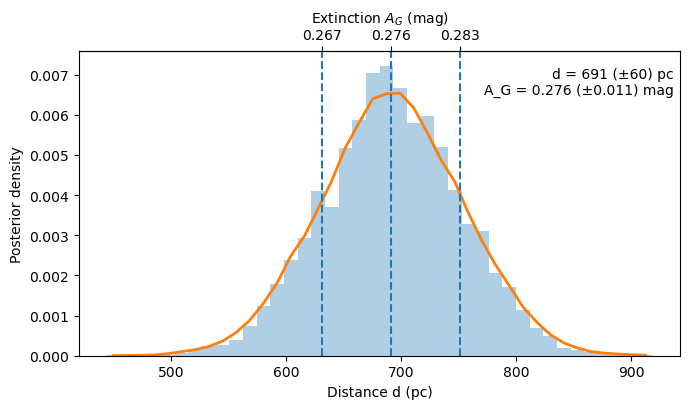

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Distance and extinction estimation with mwdust (Combined19/Bayestar19) and MC propagation.

Steps:
1) Build A_G(d) along the target line-of-sight using mwdust Combined19.
2) Solve distance from G-band photometry with BC_G=0 (as requested) and propagate
   uncertainties from (Teff, R, Gmag) plus an overall A_G scale systematic.
3) Report A_G at d = 690 ± 60 pc as a simple cross-check.

Dependencies:
  pip install numpy astropy mwdust
"""

import numpy as np
import mwdust
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import astropy.units as u


# ================== 1) Coordinates and A_G(d) from mwdust ==================
# Target ICRS coordinates (degrees)
RA, DEC = 296.3934579, 39.06696988

# Convert to Galactic (l, b)
c = SkyCoord(ra=RA * u.deg, dec=DEC * u.deg, frame='icrs')
l, b = c.galactic.l.deg, c.galactic.b.deg

# Distance grid (kpc): 0.05–2.0 with 500 points
d_kpc = np.linspace(0.05, 2.0, 500)

# mwdust Combined19 map (includes Bayestar19)
EBV_map = mwdust.Combined19(filter='E(B-V)')
AG_map  = mwdust.Combined19(filter='Gaia G')

# E(B-V)(d) and A_G(d) from the map (E(B-V) only used for the k_G scaling below)
EBV = EBV_map(l, b, d_kpc)      # E(B-V)(d)  [mag]
# If you prefer to use the map-provided A_G directly, you can also call: AG_map(l, b, d_kpc)
# Here we follow your instruction to scale via k_G:
k_G = 2.6                        # A/F-type typical; as requested
A_G = k_G * EBV                  # A_G(d) [mag] via simple scaling

dist_pc   = np.asarray(d_kpc, float) * 1e3   # kpc -> pc
A_G_curve = np.asarray(A_G,   float)         # ensure 1D float arrays


# ================== 2) Distance inference with BC_G=0 and MC ==================
# Observational inputs (mean ± 1σ)
Teff, eTeff = 7724.0, 36.0        # K
R,    eR    = 2.043, 0.183        # R_sun (upper/lower averaged to ~0.183)
Gmag        = 11.438665           # mag

# G-band uncertainty derived from flux error (or set a manual floor, e.g. 0.001 mag)
FG, eF = 500588.36403, 1.1442e2   # e-/s
eG     = 1.0857362 * (eF / FG)    # ≈ 0.00025 mag

# Solar constants
T_sun, Mbol_sun = 5772.0, 4.74

def Mbol_from_T_R(Teff_K, R_Rsun, T_sun=5772.0, Mbol_sun=4.74):
    """Bolometric absolute magnitude from Stefan–Boltzmann law."""
    L_over_Lsun = (R_Rsun**2) * (Teff_K / T_sun)**4
    return Mbol_sun - 2.5*np.log10(L_over_Lsun)

def _interp_monotone(xq, x, y):
    """Linear interpolation with gentle monotonic smoothing (clip small wiggles)."""
    y = np.maximum.accumulate(np.asarray(y, float))
    return np.interp(np.atleast_1d(xq), np.asarray(x, float), y,
                     left=y[0], right=y[-1])

def solve_distance_scalar(Gmag, MG, dist_pc, A_G_curve, tol_rel=1e-4, maxiter=80):
    """
    Solve f(d)= G - A_G(d) - M_G - 5 log10(d/10) = 0 for d (pc) by bisection.
    """
    def f(d):
        mu = 5.0*np.log10(d/10.0)
        Ag = _interp_monotone(d, dist_pc, A_G_curve)
        return Gmag - Ag - MG - mu

    dlo, dhi = max(1.0, float(dist_pc[0])), float(dist_pc[-1])
    flo, fhi = f(dlo), f(dhi)
    if flo * fhi > 0:
        dhi = 1e5
        fhi = f(dhi)
        if flo * fhi > 0:
            raise RuntimeError("No root found within [%.1f, %.1f] pc; "
                               "check G/MG/A_G consistency." % (dlo, dhi))

    for _ in range(maxiter):
        dm = 0.5*(dlo + dhi)
        fm = f(dm)
        if abs(fm) < 1e-6 or (dhi - dlo)/dm < tol_rel:
            return dm
        if flo * fm <= 0:
            dhi, fhi = dm, fm
        else:
            dlo, flo = dm, fm
    return 0.5*(dlo + dhi)

# Point estimate with BC_G=0 (as requested)
Mbol = Mbol_from_T_R(Teff, R, T_sun, Mbol_sun)
M_G  = Mbol                  # BC_G = 0 by request
d_pc = solve_distance_scalar(Gmag, M_G, dist_pc, A_G_curve)

def distance_mc(Teff, eTeff, R, eR, Gmag, eG, dist_pc, A_G_curve,
                AG_scale_sigma_frac=0.0, N=5000, seed=42):
    """
    Monte Carlo propagation.
    AG_scale_sigma_frac: relative 1σ for a global A_G scaling systematic
                         (e.g., 0.10/2.60 if k_G=2.60±0.10).
    """
    rng = np.random.default_rng(seed)
    Te  = rng.normal(Teff, eTeff, N)
    Rr  = rng.normal(R, eR, N)
    Gs  = rng.normal(Gmag, eG, N)

    if AG_scale_sigma_frac > 0:
        scales = rng.normal(1.0, AG_scale_sigma_frac, N)
    else:
        scales = np.ones(N)

    d_samps = np.empty(N)
    for i in range(N):
        Mbol_i = Mbol_from_T_R(Te[i], Rr[i], T_sun, Mbol_sun)
        MG_i   = Mbol_i  # BC_G = 0
        try:
            d_samps[i] = solve_distance_scalar(Gs[i], MG_i, dist_pc, A_G_curve * scales[i])
        except RuntimeError:
            d_samps[i] = np.nan

    d_samps = d_samps[np.isfinite(d_samps)]
    d_med = np.nanmedian(d_samps)
    d_lo  = np.nanpercentile(d_samps, 16)
    d_hi  = np.nanpercentile(d_samps, 84)
    return d_med, d_lo, d_hi, d_samps

# Include ±0.10 on k_G=2.60 as a relative scale systematic on A_G
AG_scale_sigma_frac = 0.10 / 2.60
d_med, d_lo, d_hi, d_samps = distance_mc(
    Teff, eTeff, R, eR, Gmag, eG, dist_pc, A_G_curve,
    AG_scale_sigma_frac=AG_scale_sigma_frac, N=5000, seed=42
)
print(f"[MC 68%] d = {d_med:.0f} (+{d_hi-d_med:.0f}/-{d_med-d_lo:.0f}) pc  "
      f"(includes Teff/R/G and A_G scale systematic = {AG_scale_sigma_frac:.3f})")

def ag_at_distance(d_pc, d_kpc, ag):
    """Interpolate A_G at a given distance d_pc (pc) from (d_kpc, ag) curve."""
    d_pc_grid = np.asarray(d_kpc, float) * 1e3  # kpc -> pc
    ag = np.asarray(ag, float)
    # enforce gentle monotonicity to suppress tiny interpolation noise
    ag_mono = np.maximum.accumulate(ag)
    dq = np.clip(d_pc, d_pc_grid[0], d_pc_grid[-1])
    return float(np.interp(dq, d_pc_grid, ag_mono))

d_med_pc = 690.0
d_sig_pc = 60.0
d16 = d_med_pc - d_sig_pc
d50 = d_med_pc
d84 = d_med_pc + d_sig_pc

ag16 = ag_at_distance(d16, d_kpc, A_G)
ag50 = ag_at_distance(d50, d_kpc, A_G)
ag84 = ag_at_distance(d84, d_kpc, A_G)

print(f"A_G ≈ {ag50:.3f} (+{ag84-ag50:.3f}/-{ag50-ag16:.3f}) mag  (from d = 690 ± 60 pc)")

if 'd_kpc' not in globals():
    d_kpc = np.linspace(0.05, 2.0, 500)  # kpc
if 'ag' not in globals():
    ag = 0.32 * (1.0 - np.exp(-d_kpc/0.35))
if 'd_samps' not in globals():
    rng = np.random.default_rng(42)
    d_samps = rng.normal(690.0, 60.0, 20000)

def ag_of_d(d_pc_query, d_kpc_grid, ag_grid):
    d_pc_grid = np.asarray(d_kpc_grid, float) * 1e3
    ag_grid = np.maximum.accumulate(np.asarray(ag_grid, float))
    d_pc_query = np.asarray(d_pc_query, float)
    d_pc_query = np.clip(d_pc_query, d_pc_grid[0], d_pc_grid[-1])
    return np.interp(d_pc_query, d_pc_grid, ag_grid)

def d_of_ag(ag_query, d_kpc_grid, ag_grid):
    d_pc_grid = np.asarray(d_kpc_grid, float) * 1e3
    ag_grid = np.maximum.accumulate(np.asarray(ag_grid, float))
    ag_query = np.asarray(ag_query, float)
    ag_query = np.clip(ag_query, ag_grid[0], ag_grid[-1])
    return np.interp(ag_query, ag_grid, d_pc_grid)

q16, q50, q84 = np.percentile(d_samps, [16, 50, 84])
ag16, ag50, ag84 = ag_of_d([q16, q50, q84], d_kpc, ag)

fig, ax = plt.subplots(figsize=(7, 4.2))
bins = int(np.sqrt(d_samps.size) / 2)
bins = max(40, min(bins, 200))
hist_vals, bin_edges, _ = ax.hist(d_samps, bins=bins, density=True, alpha=0.35)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
if len(hist_vals) >= 5:
    w = 5
    kernel = np.ones(w) / w
    smooth = np.convolve(hist_vals, kernel, mode='same')
    ax.plot(bin_centers, smooth, linewidth=2)

for x in (q16, q50, q84):
    ax.axvline(x, linestyle='--', linewidth=1.5)

ax.set_xlabel("Distance d (pc)")
ax.set_ylabel("Posterior density")

def forward(d_pc):
    return ag_of_d(d_pc, d_kpc, ag)

def inverse(ag_val):
    return d_of_ag(ag_val, d_kpc, ag)

ax_top = ax.secondary_xaxis('top', functions=(forward, inverse))
ax_top.set_xlabel("Extinction $A_G$ (mag)")

ax_top.set_ticks([ag16, ag50, ag84])
from matplotlib.ticker import FixedFormatter
ax_top.xaxis.set_major_formatter(FixedFormatter([f"{ag16:.3f}", f"{ag50:.3f}", f"{ag84:.3f}"]))

txt = (f"d = {q50:.0f} (±60) pc\n"
             f"A_G = {ag50:.3f} (±0.011) mag")
ax.text(0.99, 0.95, txt, ha='right', va='top', transform=ax.transAxes)

fig.tight_layout()
fig.savefig("posterior_d_with_top_AG.png", dpi=300)